In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import matrix_rank, inv
from pprint import pprint
import warnings
import random
import scipy.special as scis
import scipy.spatial as scispa
import matplotlib.cm as cm
from scipy.optimize import minimize


In [2]:
# Function to compute velocity profile u/U as a function of y and t for fixed U and nu
def velocity_profile_rayleigh(y, nu, U, t):
    return U * (1 - erf(y / (2 * np.sqrt(nu * t))))
# Generate samples in the dataset
y_values        = np.linspace(0.01, 1, 500)                    # Distance from the plate (m)
t_values        = np.linspace(0.01, 5, 10)                 # Time values (s)
n_samples       = 1                                        # Number of samples for U and nu
U      = np.random.uniform(0.8, 1.0, n_samples)   # Plate velocity (m/s)
nu      = np.random.uniform(1e-3, 1e-2, n_samples) # Kinematic viscosity (m^2/s)
u_list          = []
parameters_list = []

# Initialize arrays
u_restacked = []
y_restacked = []

# Reshape u and y by t and samples
for t_index, t in enumerate(t_values):
    u_t_list = []
    y_t_list = []
    for sample_index in range(n_samples):
        for y in y_values:
            # Extract `u` and `y` for each sample and time
            u_value = velocity_profile_rayleigh(y, nu[sample_index], U[sample_index], t)
            u_t_list.append(u_value)
            y_t_list.append(y)
    u_restacked.append(u_t_list)
    y_restacked.append(y_t_list)

# Convert to arrays
u_restacked = np.array(u_restacked)  # Shape: (len(t_values), len(y_values) * n_samples)
y_restacked = np.array(y_restacked)  # Shape: (len(t_values), len(y_values) * n_samples)

# Reshape to (number_t, number_samples)
u_final = u_restacked.reshape(len(t_values), -1)  # Flatten along y for each t
y_final = y_restacked.reshape(len(t_values), -1)

# Check shapes
print(f"u_final shape: {u_final.shape}")  # Should be (len(t_values), len(y_values) * n_samples)
print(f"y_final shape: {y_final.shape}")


u_final shape: (10, 500)
y_final shape: (10, 500)


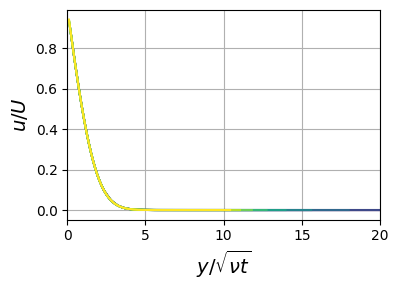

In [3]:
plt.figure(figsize=(4, 3))

# Assign colors for different time steps
colors = plt.cm.viridis(np.linspace(0, 1, len(t_values)))

for i, t in enumerate(t_values):
    # Extract corresponding u and y for the time step
    u_normalized = u_final[i] / U  # Normalize u by U
    y_scaled = y_final[i] / np.sqrt(nu * t)  # Scale y by sqrt(nu * t)
    
    # Plot each time step with a unique color
    plt.plot(y_scaled, u_normalized, label=f"t={t:.2f}", color=colors[i])

# Customize plot
plt.xlabel(r"$y / \sqrt{\nu t}$", fontsize=14)
plt.ylabel(r"$u / U$", fontsize=14)
plt.grid(True)
#plt.legend(title="Time (s)", fontsize=10)
plt.tight_layout()
plt.xlim([0,20])
plt.show()

In [4]:
### Collapse the profiles

def loss(var, xin, yin):
    vari  = np.reshape(var,(len(t_values),2))
    xtran = vari[:,0][:,np.newaxis]*xin
    ytran = vari[:,1][:,np.newaxis]*yin    
    # interpolate at the transformed coordinates grid
    ninterp = np.shape(ytran)[1]
    llim    = np.max(np.amin(xtran,axis=1))
    ulim    = np.min(np.amax(xtran,axis=1))
    newgr   = np.linspace(llim,ulim,ninterp)
    new_y   = np.zeros((len(t_values),ninterp))
    for i in range(len(t_values)):
        new_y[i,:] = np.interp(newgr,xtran[i,:],ytran[i,:])
    
    # compute distances
    dist_mat = np.zeros((len(t_values),len(t_values)))
    for i in range(len(t_values)):
        for j in range(len(t_values)):
            dist_mat[i,j] = (np.linalg.norm(new_y[i,:] - new_y[j,:]))**2
            
    dist = np.sum(dist_mat)/2.0
    
    return dist

# Define parameters and initialise transformation matrices
varopt = np.ones((2*len(t_values)))

bounds = np.zeros((2*len(t_values),2))
bounds[:,0] = 0.05
bounds[:,1] = None

# Optimisation
res = minimize(loss, varopt, args=(y_final, u_final), bounds=bounds)

varm = np.reshape(res.x,(len(t_values),2))
t1   = varm[:,0]
t2   = varm[:,1]

In [5]:
def normalise(field,transform):    
    fmin = np.average(np.min(field,axis=1))
    fmax = np.average(np.max(field,axis=1))
    f_norm = (field-fmin)/(fmax-fmin)
    t_norm = (transform-fmin)/(fmax-fmin)
    
    return f_norm, t_norm
    
xtran = np.zeros_like(y_final)
ytran = np.zeros_like(u_final)
for i in range(len(t_values)):
    xtran[i,:]=y_final[i,:]*t1[i]
    ytran[i,:]=u_final[i,:]*t2[i]
xtran2, t1n = normalise(xtran,t1)
ytran2, t2n = normalise(ytran,t2)

In [6]:
### Interpret transformations

# Loss function
def loss(var, target, target_dims, A, A_dims, w1):
    f = np.ones((np.size(target)))
    for i in range(np.shape(A)[1]):
        temp = np.power(A[:,i],var[i+1])
        f   = np.multiply(f,temp)
    f = var[0]*f
    f = np.reshape(f,(np.size(f),1)) 
    
    f_dims = np.matmul(A_dims,var[1:])
    f_dims = np.reshape(f_dims,(np.size(f_dims),1)) 

    dist = np.sum((f - target)**2) + w1*np.sum(np.abs(f_dims - target_dims))
    
    return dist

# Interpret first identified transformation (alpha)
Xsr1   = np.array([np.tile(U,len(t_values)), np.tile(nu,len(t_values)), t_values]).T
X_dims = np.array([[1,2,0],[0,0,0],[-1,-1,1]]) ## L, M, T

Ysr1 = 1/t1n.copy()
Ysr1 = np.reshape(Ysr1,(np.size(Ysr1),1))
Y_dims = np.array([[1],[0],[0]]) ## L, M, T

weight_dims = 1e-4

# Run optimisation
niter = 30
fmin  = 1e20
for i in range(niter):
    var = np.ones((np.shape(Xsr1)[1]+1,1)) # adding a multiplitative constant to the power law
    var = var.flatten()*np.random.rand(np.size(var))
    
    res = minimize(loss, var, args=(Ysr1, Y_dims, Xsr1, X_dims, weight_dims))
    if (res.fun < fmin):
        fmin   = res.fun
        var_b1 = res.x

print("The found constant and powers are:", var_b1)
f = np.ones((np.size(Ysr1)))
for i in range(np.shape(Xsr1)[1]):
    temp = np.power(Xsr1[:,i],var_b1[i+1])
    f    = np.multiply(f,temp)
f = var_b1[0]*f
f = np.reshape(f,(np.size(f),1))

f_dims = np.matmul(X_dims,var_b1[1:])
print("The dimensions of the found expression are:", f_dims)

The found constant and powers are: [8.62945775 0.2958669  0.35206654 0.33751047]
The dimensions of the found expression are: [ 0.99999997  0.         -0.31042297]


In [7]:
# Interpret second identified transformation (beta)
Xsr2   = np.array([np.tile(U,len(t_values)), np.tile(nu,len(t_values)), t_values]).T
X_dims = np.array([[1,2,0],[0,0,0],[-1,-1,1]]) ## L, M, T

Ysr2   = 1/t2n.copy()
Ysr2   = np.reshape(Ysr2,(np.size(Ysr2),1))
Y_dims = np.array([[1],[0],[-1]]) ## L, M, T

weight_dims = 1e-4

# Run optimisation
niter = 30
fmin  = 1e20
for i in range(niter):
    var = np.ones((np.shape(Xsr2)[1]+1,1)) # adding a multiplitative constant to the power law
    var = var.flatten()*np.random.rand(np.size(var))
   
    res = minimize(loss, var, args=(Ysr2, Y_dims, Xsr2, X_dims, weight_dims))
    if (res.fun < fmin):
        fmin   = res.fun
        var_b2 = res.x
print("The found constant and powers are:", var_b2)
f = np.ones((np.size(Ysr2)))
for i in range(np.shape(Xsr2)[1]):
    temp = np.power(Xsr2[:,i],var_b2[i+1])
    f    = np.multiply(f,temp)
f = var_b2[0]*f
f = np.reshape(f,(np.size(f),1))

f_dims = np.matmul(X_dims,var_b2[1:])
print("The dimensions of the found expression are:", f_dims)

The found constant and powers are: [ 0.27938848  1.3671413  -0.18357065  0.18342465]
The dimensions of the found expression are: [ 1.00000001  0.         -1.000146  ]
